In [1]:
import numpy as np
import openpyxl.utils


import torch
import pylab as plt
from munch import munchify
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader

from utils import *
from tqdm import tqdm
%matplotlib inline

In [7]:
# datafile to load the data. This cell and the next cell are just for having some sense of how to feed data.
# Please load your own data and make them similar to the shape of data in dataset.
project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
data_root = 'data'
test_setName= 'Exact_UVA_patches_400_100_100_maskedProstate_01-30-2022.mat'
data_file = '/'.join([project_root, data_root, test_setName])
print('loading data...')
input_data = load_matlab(data_file)
print('loading done!')

num_workers = 0
device = torch.device(f'cuda:0' if torch.cuda.is_available() else 'cpu')

loading data...
loading done!


In [39]:
input_data = dataset.preprocess(input_data, norm='mean0var1', shffl_patients=False, signal_split=False,
                        split_rs=26, val_size=0.25, augment=False)

AttributeError: 'TensorDataset' object has no attribute 'preprocess'

In [45]:
# This function takes in net, device, and pair of (input, label, location) and produces output
# This is used in the next cell
def drop_eval(net, x_raw, n_batch, T_samples):
    pred_list, unc_list = [], []
    for i in range(T_samples):
        out1 = net(x_raw, n_batch)
        pred = F.softmax(out1, dim=1)
        pred_list.append(torch.unsqueeze(pred, dim=0))
    pred_mean = torch.cat(pred_list, 0).mean(dim=0)
    confidence,_ = torch.max(pred_mean, dim=1)
    unc = 1. - confidence
    return pred_mean, unc


def predict(net, input_data, input_label, device, unc_method, T_samples=30, unc_thr=0.2):
    from sklearn.metrics import confusion_matrix


    # location is not important here, so we make it up randomly
    input_location = torch.ones_like(input_label)

    outputs = []
    entropic_scores = []
    uncertainty = []
    total = correct = 0

    cm = np.zeros((2,2))
    cm_unc = np.zeros((2,2))

    no_data = len(input_data)
    batch_size = 32
    no_batch = no_data//batch_size
    # print('no batches and batch size:', no_batch, batch_size)
    # built-in function of class torch.utils.Dataset which sets model in evaluation mode
    # (here both evaluation and training are the same)
    net.eval()
    # apply model on test signals
    with torch.no_grad():
        for i in range(no_batch+1):
            strt = i*batch_size
            end = (i+1)*batch_size
            x_raw, y_batch, n_batch = input_data[strt:end,...], input_label[strt:end,...], input_location[strt:end,...]
            x_raw, y_batch, n_batch = x_raw.to(device), y_batch.to(device), n_batch.to(device)

            if unc_method=='dropout':
                # pred and uncertainty (1-confidence) of dropout
                pred, unc = drop_eval(net, x_raw, n_batch, T_samples)
            elif unc_method=='edl':
                out1 = net(x_raw, n_batch)
                pred = F.softmax(out1, dim=1)

                alpha = F.relu(out1) + 1
                unc = 2. / torch.sum(alpha, dim=1, keepdim=True).reshape(-1)
            elif unc_method=='vanilla':
                out1 = net(x_raw, n_batch)
                pred = F.softmax(out1, dim=1)
                crnt, _ = torch.max(pred, dim=1)
                unc = 1-crnt

            probabilities = pred  # torch.nn.Softmax(dim=1)(pred)
            entropies = -(probabilities * torch.log(probabilities)).sum(dim=1)
            entropic_scores.append((-entropies).cpu().numpy())

            uncertainty.append(unc.cpu().numpy())

            outputs.append(pred.cpu().numpy())
            total += y_batch.size(0)
            correct += (pred.argmax(dim=1) == torch.argmax(y_batch, dim=1)).sum().item()

            cm += confusion_matrix(y_batch.argmax(dim=1).cpu(), pred.argmax(dim=1).cpu(), labels=[0,1])
            ind_unc = unc<=unc_thr
            cm_unc += confusion_matrix((y_batch[ind_unc, ...]).argmax(dim=1).cpu(),
                                       (pred[ind_unc, ...]).argmax(dim=1).cpu(), labels=[0,1])


    tn, fp, fn, tp = cm.ravel()
    tn_unc, fp_unc, fn_unc, tp_unc = cm_unc.ravel()
    acc_sb = (tp/(tp+fn) + tn/(tn+fp))/2.0
    acc_sb_unc = (tp_unc/(tp_unc+fn_unc) + tn_unc/(tn_unc+fp_unc))/2.0

    outputs = np.concatenate(outputs)
    uncertainty = np.concatenate(uncertainty)
    entropic_scores = np.concatenate(entropic_scores)
    return outputs, uncertainty, entropic_scores, correct / total, acc_sb, acc_sb_unc

def infer_core_wise2(predictions, uncertainty, core_len, roi_coors, unc_thr, ood_scores=None):
    """
    Infer core-wise predictions based on signal-wise predictions.
    Input must be 1-D array
    :param predictions: signal-wise predictions
    :param core_len: length of each core
    :param roi_coors: pixel-wise coordinates of ROI area
    :param ood_scores:
    :return:
    """
    counter = 0
    no_uncCores = 0
    core_feat1, core_res1, core_l1, core_l2, core_l3, core_ood = [], [], [], [], [], []
    prediction_maps = []

    # find a label for each core
    for i in range(len(core_len)):
        temp = predictions[counter:(counter + core_len[i])]
        un = uncertainty[counter:(counter + core_len[i])]
        temp2 = temp[un <= unc_thr, ...]
        if len(temp2) <= np.round(0.6*core_len[i]):
            no_uncCores += 1
            core_l3.append(np.nan)
        else:
            core_l3.append(np.greater(temp2[:, 1], temp2[:, 0]).sum() / len(temp2))

        core_l1.append(np.greater(temp[:, 1], temp[:, 0]).sum() / core_len[i])
        core_l2.append(temp[:, 1].sum() / core_len[i])
        core_ood.append(ood_scores)
        counter += core_len[i]

    if no_uncCores!=0:
        print(f'no uncertain cores {no_uncCores}')
    return (core_l1, core_l2, core_l3), core_ood, prediction_maps

In [46]:
def net_interpretation2(predicted_label, patient_id, involvement, gleason_score, result_dir=None,
                       ood=None, cct=(0.2, 0.6, 1), cbt=(0, 1, 0.6), cf=(1, 0.2, 0.6),
                       current_epoch=None, set_name='Test', writer=None, scores: dict = None, threshold=0.5,
                       plotting=True,  edl=False):
    import seaborn as sns
    predicted_label_nounc = predicted_label[0]
    # in case edl is not used
    predicted_label_unc = predicted_label[1]
    pred_inv_wNan = predicted_label[1]

    if edl:
        pred_inv_wNan = predicted_label[2]
        predicted_label_unc = np.array([pred_inv_wNan[i] for i in range(len(pred_inv_wNan))
                                              if not np.isnan(pred_inv_wNan[i])])

    # predicted_label = np.array([item > 0.5 for item in predicted_label])
    true_label = np.array([item > 0 for item in involvement])

    predicted_label_th = np.array(predicted_label_nounc)
    predicted_label_th[predicted_label_th > threshold] = 1
    predicted_label_th[predicted_label_th <= threshold] = 0

    andlabels = np.logical_and(predicted_label_th, true_label)

    patients = np.unique(patient_id)
    # Invs = np.ones_like(involvement)
    Invs = involvement * 100
    gs = np.array(gleason_score)
    indx = []
    maxc = 0
    for ip in patients:
        temp = np.where(patient_id == ip)[0]
        indx.append(temp)
        maxc = max(maxc, len(temp))

    inv = np.zeros((len(patients), maxc), dtype=float)
    #    cmaps=[]

    label = []
    cmap = [cf if True else [0, 0, 1] for i in range(len(true_label))]

    for i in range(len(true_label)):
        if andlabels[i] == 1:
            cmap[i] = cct
        elif (predicted_label_th[i] + true_label[i]) == 0:
            cmap[i] = cbt
        else:
            cmap[i] = cf
    cmap = np.array(cmap)
    cmaps = np.zeros((len(patients), maxc, 3), dtype=float)
    for ip in range(len(patients)):
        indxip = indx[ip]
        inv[ip, :len(indxip)] = Invs[indxip]
        cmaps[ip, :len(indxip)] = cmap[indxip]
        label.append(gs[indxip])
        for i in range(len(label[ip])):
            if label[ip][i] == 'Benign':
                inv[ip, i] = 50
                label[ip][i] = '-'
            if label[ip][i] == 'FB':
                inv[ip, i] = 50
                label[ip][i] = '-'

    fig1, ax1 = plt.subplots()
    #todo: might overkill memory
    fig1.set_size_inches(18.5*2, 10.5*2)
    barbase = np.cumsum(np.concatenate((np.zeros((inv.shape[0], 1)), inv[:, 0:-1]), axis=1), 1)

    for i in range(maxc):
        ax1.bar(np.arange(len(patients)), inv[:, i].tolist(), 0.7, bottom=barbase[:, i], color=cmaps[:, i])
        ax1.EdgeColor = 'k'
    plt.xticks(np.arange(len(patients)), patients.astype(int))
    plt.xlabel('Patient No.')

    width = np.array([p.get_width() for p in ax1.patches][0]).squeeze()
    joblblpos = inv / 2 + barbase
    for k1 in range(inv.shape[0]):
        for k2 in range(inv.shape[1]):
            plt.text(k1-width/2., joblblpos[k1, k2], label[k1][k2] if inv[k1, k2] != 0 else '')
    # plt.savefig(f'{result_dir}/{set_name}_acc_per_core{current_epoch_str}.png')
    if plotting:
        plt.show()

    ood_sum = np.array([-_ood.sum() for _ood in ood])
    ood_normalized = ood_sum / ood_sum.sum()

    fig2 = plt.figure(2)
    ax2 = sns.scatterplot(x=involvement, y=predicted_label_nounc, size=ood_normalized, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax2)
    ax2.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax2.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax2.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax2.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax2.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax2.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax2.axis('square')
    ax2.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])
    if scores is not None:
        ax1.set_title(f'ACC: {scores["acc"]:.2f} | ACC_B: {scores["acc_b"]:.2f} '
                      f'AUC: {scores["auc"]:.2f} | SEN: {scores["sen"]:.2f} | SPE: {scores["spe"]:.2f}')
        ax2.set(title=f'Correlation Coefficient = {scores["corr"]:.3f} | MAE = {scores["mae"]:.3f}',
                xlabel='True Involvement', ylabel='Predicted Involvement'
                )
    # plt.savefig('point_cloud3.png')
    if plotting:
        plt.show()

#############################################################################################
    # new plot based on new way of finding core predictions
    predicted_label_th_unc = np.copy(np.array(pred_inv_wNan))
    predicted_label_th_unc[predicted_label_th_unc > threshold] = 1
    predicted_label_th_unc[predicted_label_th_unc <= threshold] = 0

    andlabels_unc = np.logical_and(predicted_label_th_unc, true_label)

    label = []
    cmap = [cf if True else [0, 0, 1] for i in range(len(true_label))]

    for i in range(len(true_label)):
        if andlabels_unc[i] == 1:
            cmap[i] = cct
        elif (predicted_label_th_unc[i] + true_label[i]) == 0:
            cmap[i] = cbt
        else:
            cmap[i] = cf
        if np.isnan(pred_inv_wNan[i]):
            cmap[i] = (.9,.9,.9)

    cmap = np.array(cmap)
    cmaps = np.zeros((len(patients), maxc, 3), dtype=float)
    for ip in range(len(patients)):
        indxip = indx[ip]
        inv[ip, :len(indxip)] = Invs[indxip]
        cmaps[ip, :len(indxip)] = cmap[indxip]
        label.append(gs[indxip])
        for i in range(len(label[ip])):
            if label[ip][i] == 'Benign':
                inv[ip, i] = 50
                label[ip][i] = '-'
            if label[ip][i] == 'FB':
                inv[ip, i] = 50
                label[ip][i] = '-'

    fig3, ax3 = plt.subplots()
    fig3.set_size_inches(18.5*2, 10.5*2)

    for i in range(maxc):
        ax3.bar(np.arange(len(patients)), inv[:, i].tolist(), 0.7, bottom=barbase[:, i], color=cmaps[:, i])
        ax3.EdgeColor = 'k'
    plt.xticks(np.arange(len(patients)), patients.astype(int))
    plt.xlabel('Patient No.')

    width = np.array([p.get_width() for p in ax3.patches][0]).squeeze()
    joblblpos = inv / 2 + barbase
    for k1 in range(inv.shape[0]):
        for k2 in range(inv.shape[1]):
            plt.text(k1-width/2., joblblpos[k1, k2], label[k1][k2] if inv[k1, k2] != 0 else '')
    if plotting:
        plt.show()

    fig4 = plt.figure(4)
    inv_unc = np.array([involvement[i] for i in range(len(pred_inv_wNan))
              if not np.isnan(pred_inv_wNan[i])])
    ood_unc = np.array([ood_normalized[i] for i in range(len(pred_inv_wNan))
              if not np.isnan(pred_inv_wNan[i])])
    if len(inv_unc)==0:
        inv_unc = [1.]
        predicted_label_unc = [0.]
        ood_unc = ood_normalized[0]
    ax4 = sns.scatterplot(x=inv_unc, y=predicted_label_unc, size=ood_unc, legend=False)
    diag = np.arange(0, 1, .05)
    sns.lineplot(x=diag, y=diag, color='r', ax=ax4)
    ax4.axvspan(-.1, 0.1, -.1, .5, alpha=.2, facecolor='lightgreen')
    ax4.axvspan(-.1, 0.1, .51, 1., alpha=.2, facecolor='red')
    ax4.axvspan(0.11, 1.1, -.1, .5, alpha=.2, facecolor='grey')
    ax4.axvspan(0.11, 1.1, .51, 1., alpha=.2, facecolor='moccasin')
    ax4.axvline(x=.105, linewidth=.6, linestyle='--', color='black')
    ax4.axhline(y=.505, linewidth=.6, linestyle='--', color='black')
    ax4.axis('square')
    ax4.set(ylim=[-.1, 1.1], xlim=[-.1, 1.1])

    if plotting:
        plt.show()

    if writer:
        # img = plot_to_image(fig4)
        writer.add_figure(f'{set_name}/core_acc', fig1, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_inv_threshold', fig2, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_acc_mean', fig3, global_step=current_epoch)
        writer.add_figure(f'{set_name}/core_inv_mean', fig4, global_step=current_epoch)

    plt.close('all')

In [157]:
def test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList):
    all_accb=[]
    all_accb_unc=[]
    all_accsb_unc=[]
    for srs in srs_list:
        for seed in seed_list:
            accb=[]
            accb_unc=[]
            accsb_unc=[]

            project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
            args = {}
            args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
            args['exp_suffix'] = exp_suffix[0] + f'{srs}' + exp_suffix[1] + f'{seed}' + exp_suffix[2]

            with open(args['config']) as f:
                opt = yaml.load(f, Loader)
            opt.update(args)
            opt = munchify(opt)
            opt.project_root = project_root
            opt = setup_directories(opt)
            opt.core_th = 0.5

            if exp_name == 'edl':
                opt.loss_name = 'edl'
                opt.dropout.rate = 'none'
            elif exp_name == 'dropout':
                opt.loss_name = 'ce'
                opt.dropout.rate = 0.1
            elif exp_name == 'vanilla':
                opt.loss_name = 'ce'
                opt.dropout.rate = 'none'

            net = construct_network(device, opt)
            net = net[0]()
            suffix = '_1'

            try:
                net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth', map_location='cuda:0'))
            except:
                continue
            print("srs and seed:",srs, seed)

            # arr = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
            # arr = [1., 0.5, 0.3, 0.2, 0.15, 0.1, 0.075, 0.05,0.025]
            thr_list = unc_thrList
            for thr in thr_list:
                predictions, uncertainty, ood_scores, acc_s, acc_sb, acc_sb_unc = predict(net, x_data, y_label, device, exp_name, unc_thr=thr)
                predicted_involvement, ood, prediction_maps = infer_core_wise2(predictions, uncertainty, core_len, roi_coors, thr, ood_scores)

                scores = {'acc_s': acc_s, 'acc_sb': acc_sb,'acc_sb-unc':acc_sb_unc}
                scores = compute_metrics(predicted_involvement, true_involvement, current_epoch=0, verbose=False, scores=scores,
                                         threshold=opt.core_th, edl=True)
                # net_interpretation2(predicted_involvement, patient_id_bk, true_involvement, gs_bk, opt.paths.result_dir, ood=ood,
                #                     current_epoch=0, set_name=state, writer=False, scores=scores, threshold=opt.core_th, plotting=True, edl=True)

                accb.append(scores['acc_b'])
                accb_unc.append(scores['acc_b-uncrtan'])
                accsb_unc.append(scores['acc_sb-unc'])

            print(accb_unc)
            all_accb.append(accb)
            all_accb_unc.append(accb_unc)
            all_accsb_unc.append(accsb_unc)
    return all_accb, all_accb_unc, all_accsb_unc

In [189]:
def test_uncertainty_ensemble(srs_list, seed_list, exp_name, exp_suffix, unc_thrList):
    all_accb=[]
    all_accb_unc=[]
    all_accsb_unc=[]
    for srs in srs_list:
        preds_seed = []
        for seed in seed_list:
            accb=[]
            accb_unc=[]
            accsb_unc=[]

            preds_thr = []

            project_root = 'C:/Users/Mahdi/Desktop/Summer21/RA/Codes/Minh_Mahdi_mod/prostate_cancer_classification'
            args = {}
            args['config'] = '../yamls/coteaching_local_inference_Exact2D.yml'
            args['exp_suffix'] = exp_suffix[0] + f'{srs}' + exp_suffix[1] + f'{seed}' + exp_suffix[2]

            with open(args['config']) as f:
                opt = yaml.load(f, Loader)
            opt.update(args)
            opt = munchify(opt)
            opt.project_root = project_root
            opt = setup_directories(opt)
            opt.core_th = 0.5


            if exp_name == 'ensm':
                opt.loss_name = 'ce'
                opt.dropout.rate = 'none'


            net = construct_network(device, opt)
            net = net[0]()
            suffix = '_1'

            try:
                net.load_state_dict(torch.load(f'{opt.project_root}/{opt.paths.checkpoint_dir}/{opt.test.which_iter}_coreN{suffix}.pth', map_location='cuda:0'))
            except:
                continue
            print("srs and seed:",srs, seed)

            thr_list = unc_thrList
            for thr in thr_list:
                predictions, uncertainty, ood_scores, acc_s, acc_sb, acc_sb_unc = predict(net, x_data, y_label, device, 'vanilla', unc_thr=thr)
                preds_thr.append(predictions)
            temp_thr = np.stack(preds_thr, axis=0)
            preds_seed.append(temp_thr)

        seed_predictions = np.stack(preds_seed, axis=0) ## [seed, thr, n, 2 classes]
        srs_predictions = np.mean(seed_predictions, axis=0) ## [thr, n, 2]
        uncertainty = 1. - np.max(srs_predictions, axis=-1)

        for ii, thr in enumerate(thr_list):
            predicted_involvement, ood, prediction_maps = infer_core_wise2(srs_predictions[ii,...], uncertainty[ii,...], core_len, roi_coors, thr, ood_scores)

            ind_unc = uncertainty[ii,...]<=thr
            acc_sb_unc = ((srs_predictions[ii,...])[ind_unc,...].argmax(axis=1) == ((y_label.cpu().numpy())[ind_unc,...]).argmax(axis=1))
            acc_sb_unc = acc_sb_unc.sum()/len((srs_predictions[ii,...])[ind_unc,...])
            scores = {'acc_sb-unc':acc_sb_unc}

            scores = compute_metrics(predicted_involvement, true_involvement, current_epoch=0, verbose=False, scores=scores,
                                     threshold=opt.core_th, edl=True)
            # net_interpretation2(predicted_involvement, patient_id_bk, true_involvement, gs_bk, opt.paths.result_dir, ood=ood,
            #                     current_epoch=0, set_name=state, writer=False, scores=scores, threshold=opt.core_th, plotting=True, edl=True)

            accb.append(scores['acc_b'])
            accb_unc.append(scores['acc_b-uncrtan'])
            accsb_unc.append(scores['acc_sb-unc'])

        print(accb_unc)
        all_accb.append(accb)
        all_accb_unc.append(accb_unc)
        all_accsb_unc.append(accsb_unc)
    return all_accb, all_accb_unc, all_accsb_unc

In [217]:
from utils.dataset import create_datasets_test_Exact

min_inv=.4

# which dataset to use for testset. Either train, val, or test
state = 'test'
dataset, core_len, true_involvement, patient_id_bk, gs_bk, roi_coors, true_labels, *ids = create_datasets_test_Exact(
    '/'.join([project_root, data_root, test_setName]), dataset_name='Exact_patched',
    min_inv=min_inv, input_data=input_data, state=state, norm='mean0var1')

# these are input data and label corresponding to them
# label is just for plotts in the next cell, you can feed a random matrix of nx2 instead
x_data = dataset.tensors[0]
y_label = dataset.tensors[1]

cancer labels shape (1051, 2)
data shape (2808, 1, 256, 256)


In [218]:
unc_thrList = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
srs_list = [26, 30, 57]
seed_list = [0,15,10]

exp_name = 'edl'
exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_edl-thr.2crr_sd','_ep200']
all_accbEdl, all_accb_uncEdl, all_accsb_uncEdl = test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

exp_name = 'vanilla'
exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
all_accbVanl, all_accb_uncVanl, all_accsb_uncVanl = test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

exp_name = 'dropout'
exp_suffix = ['_mskedPatch/crrt-ds-splt--_res10_srs','_vs.25_ce-thr.1-drp.1-30_sd','_invl1val15tst_ep200']
all_accbDrp, all_accb_uncDrp, all_accsb_uncDrp = test_uncertainty(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)

srs and seed: 26 0
no uncertain cores 4
no uncertain cores 21
no uncertain cores 43
no uncertain cores 49
no uncertain cores 62
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


no uncertain cores 74
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7919684002633312, 0.7758393680052666, 0.7718268525311812, 0.8559210526315789, 0.967741935483871, 0.8154761904761905, 1.0, 1.0, 1.0, nan, nan, nan]
srs and seed: 26 10
no uncertain cores 2
no uncertain cores 21
no uncertain cores 38
no uncertain cores 52
no uncertain cores 64
no uncertain cores 74
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7919684002633312, 0.7919684002633312, 0.8142153413089375, 0.8434210526315788, 0.8737373737373737, 1.0, 1.0, 1.0, 1.0, nan, nan, nan]
srs and seed: 30 0
no uncertain cores 1
no uncertain cores 12
no uncertain cores 30
no uncertain cores 38
no uncertain cores 50
no uncertain cores 61


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\sklearn\metrics\_classification.py:1854: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')
C:\Users\Mahdi\Desktop\Summer21\RA\Codes\Minh_Mahdi_mod\prostate_cancer_classification\utils\metrics.py:16: RuntimeWarning: invalid value encountered in longlong_scalars
  return tp / (tp + fn)  # sensitivity
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


no uncertain cores 75
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7613561553653719, 0.7613561553653719, 0.7554421768707482, 0.7973484848484849, 0.896049896049896, 0.884375, 0.8557692307692308, 0.9473684210526315, 1.0, nan, nan, nan]
srs and seed: 30 10
no uncertain cores 7
no uncertain cores 37
no uncertain cores 65
no uncertain cores 72
no uncertain cores 78
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7962475312705728, 0.7962475312705728, 0.8281746031746031, 0.9285714285714286, 1.0, 1.0, 1.0, nan, nan, nan, nan, nan]
srs and seed: 57 0
no uncertain cores 6
no uncertain cores 21
no uncertain cores 34
no uncertain cores 46
no uncertain cores 62
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


no uncertain cores 76
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7876892692560895, 0.7876892692560895, 0.771560236998025, 0.7942528735632184, 0.7907894736842105, 0.8198198198198199, 1.0, 1.0, 1.0, nan, nan, nan]
srs and seed: 57 10
no uncertain cores 12
no uncertain cores 43
no uncertain cores 62
no uncertain cores 72
no uncertain cores 77
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


no uncertain cores 79
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2480: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\users

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in double_scalars
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2551: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
c:\users\mahdi\anaconda3\envs\env1\lib\site-

no uncertain cores 80
exception occured!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
[0.7817643186306781, 0.8080974325213957, 0.8083720930232559, 0.9838709677419355, 0.9705882352941176, 1.0, 1.0, 1.0, nan, nan, nan, nan]
srs and seed: 26 0
no uncertain cores 1
no uncertain cores 1
no uncertain cores 3
no uncertain cores 4
no uncertain cores 8
no uncertain cores 15
no uncertain cores 23
no uncertain cores 27
[0.8113890717577353, 0.8113890717577353, 0.8275181040158, 0.8275181040158, 0.8248299319727892, 0.8248299319727892, 0.8367346938775511, 0.86281179138322, 0.8444816053511706, 0.894927536231884, 0.9209459459459459, 0.903250773993808]
srs and seed: 26 15
no uncertain cores 1
no uncertain cores 1
no uncertain cores 2
no uncertain cores 4
no uncertain cores 5
no uncertain cores 5
no uncertain cores 14
no uncertain cores 19
no uncertain cores 26
[0.7468729427254772, 0.7468729427254772, 0.7732060566161949, 0.771505376344086, 0.7876344086021505, 0.7858613589567605, 0.7739130434782608, 0.76666666666

In [227]:
unc_thrList = [1., 0.5, 0.3, 0.2, 0.15, 0.125, 0.1, 0.075, 0.05,0.025, 0.0125, 0.0075]
srs_list = [26,30,57,13,77]
seed_list = [0,5,10,15,20]

exp_name = 'ensm'
exp_suffix = ['_mskedPatch/1e-4_fr.4ngrad6_crrt-ds-splt--_res10_srs','_vs.25_ce_sd','_ep200']
all_accbEnsm, all_accb_uncEnsm, all_accsb_uncEnsm = test_uncertainty_ensemble(srs_list, seed_list, exp_name, exp_suffix, unc_thrList)


srs and seed: 26 0
srs and seed: 26 5
srs and seed: 26 10
srs and seed: 26 15
srs and seed: 26 20
no uncertain cores 3
no uncertain cores 16
no uncertain cores 31
no uncertain cores 33
no uncertain cores 35
no uncertain cores 41
no uncertain cores 45
no uncertain cores 48
no uncertain cores 55
no uncertain cores 58
[0.8242264647794602, 0.8242264647794602, 0.8308189655172413, 0.827922077922078, 0.9186274509803922, 0.9134199134199135, 0.9074519230769231, 0.9090909090909092, 0.9444444444444444, 0.9444444444444444, 0.9166666666666667, 1.0]
srs and seed: 30 0
srs and seed: 30 5
srs and seed: 30 10
srs and seed: 30 15
srs and seed: 30 20
no uncertain cores 2
no uncertain cores 11
no uncertain cores 16
no uncertain cores 21
no uncertain cores 26
no uncertain cores 29
no uncertain cores 32
no uncertain cores 43
no uncertain cores 48
no uncertain cores 53
[0.7468729427254772, 0.7468729427254772, 0.7536032944406315, 0.7804545454545455, 0.7990033222591362, 0.822829131652661, 0.8355263157894737, 0

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\numpy\lib\function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


srs and seed: 77 5
srs and seed: 77 10
srs and seed: 77 15
srs and seed: 77 20
no uncertain cores 2
no uncertain cores 13
no uncertain cores 24
no uncertain cores 31
no uncertain cores 32
no uncertain cores 36
no uncertain cores 44
no uncertain cores 49
no uncertain cores 50
no uncertain cores 53
[0.7978933508887426, 0.7978933508887426, 0.7958333333333334, 0.8571428571428572, 0.757602862254025, 0.7916666666666667, 0.7727272727272727, 0.8, 0.7946428571428572, 0.8333333333333333, 0.9, 0.875]


c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: Degrees of freedom <= 0 for slice.
  if sys.path[0] == '':


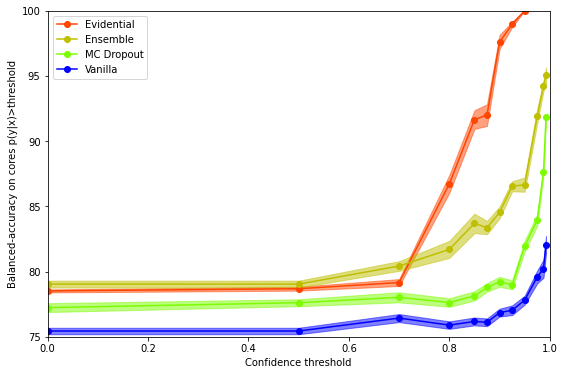

In [244]:
all_accb_unc = []
all_accsb_unc = []
color=['orangered', 'y','lawngreen','b']

fig1, ax1 = plt.subplots()
fig1.set_size_inches(9, 6)
for i, exp in enumerate(['Edl', 'Ensm','Drp', 'Vanl']):
    exec('all_accb_unc' + '= all_accb_unc'+ f'{exp}')
    exec('all_accsb_unc' + '= all_accsb_unc'+ f'{exp}')
    acc_b_stack = np.stack(all_accb_unc, axis=0)
    acc_b_mean = np.nanmean(acc_b_stack, axis=0)*100.
    acc_b_std = np.sqrt(np.nanvar(acc_b_stack, axis=0))*10.
    # fig1.set_size_inches(18.5, 10.5)
    x = 1-np.array(unc_thrList)
    ax1.plot(x, acc_b_mean, c=color[i], marker='o')
    plt.fill_between(x, acc_b_mean-acc_b_std, acc_b_mean+acc_b_std,
                     alpha=0.5, edgecolor=color[i], facecolor=color[i])

plt.xlabel('Confidence threshold')
plt.ylabel('Balanced-accuracy on cores p(y|x)>threshold')
plt.xlim(0, 1.)
plt.ylim(75, 100)
plt.legend(['Evidential', 'Ensemble', 'MC Dropout','Vanilla'])
plt.show()

c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: Mean of empty slice
  
c:\users\mahdi\anaconda3\envs\env1\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: Degrees of freedom <= 0 for slice.
  import sys


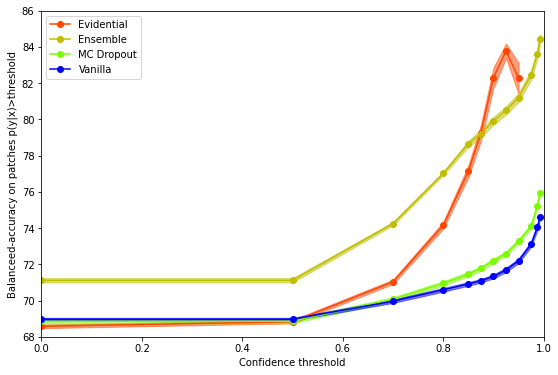

In [243]:
fig1, ax1 = plt.subplots()
fig1.set_size_inches(9, 6)
for i, exp in enumerate(['Edl', 'Ensm','Drp', 'Vanl']):
    exec('all_accsb_unc' + '= all_accsb_unc'+ f'{exp}')
    acc_sb_stack = np.stack(all_accsb_unc, axis=0)
    acc_sb_mean = np.nanmean(acc_sb_stack, axis=0)*100.
    acc_sb_std = np.sqrt(np.nanvar(acc_sb_stack, axis=0))*10.
    # fig1.set_size_inches(18.5, 10.5)
    x = 1-np.array(unc_thrList)
    ax1.plot(x, acc_sb_mean, c=color[i], marker='o')
    plt.fill_between(x, acc_sb_mean-acc_sb_std, acc_sb_mean+acc_sb_std,
                     alpha=0.5, edgecolor=color[i], facecolor=color[i])

plt.xlabel('Confidence threshold')
plt.ylabel('Balanceed-accuracy on patches p(y|x)>threshold')
plt.xlim(0, 1.)
plt.ylim(68, 86)
plt.legend(['Evidential', 'Ensemble', 'MC Dropout','Vanilla'])
plt.show()



<class 'torch.Tensor'>
